# 10: Hail Average Magnitude Forecast | Region: U.S. South
---

## 1. Imports

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime

pd.set_option('display.max_columns', None)

---
## 2. Loading Data

In [17]:
all_storms = pd.read_csv('../data/all_storms_dt_damage_clean.csv')

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


---
## 3. Organizing Data

### 3.1. Dropping Columns

In [18]:
all_storms = all_storms[['state', 'region', 'event_type', 'begin_date_time', 'magnitude']]

In [19]:
all_storms

,state,region,event_type,begin_date_time,magnitude
0,Oklahoma,South,Tornado,1950-04-28 14:45:00,0.0
1,Texas,South,Tornado,1950-06-19 20:40:00,0.0
2,Indiana,Midwest,Tornado,1950-07-19 14:30:00,0.0
3,Indiana,Midwest,Tornado,1950-07-19 17:45:00,0.0
4,Colorado,West,Tornado,1950-07-22 15:07:00,0.0
...,...,...,...,...,...
1740591,Arkansas,South,Winter Storm,2022-02-02 18:45:00,NaN
1740592,Arkansas,South,Winter Weather,2022-02-03 02:50:00,NaN
1740593,Arkansas,South,Winter Storm,2022-02-03 01:00:00,NaN
1740594,Massachusetts,Northeast,Heavy Snow,2022-02-25 00:00:00,NaN


In [20]:
# Casting the begin_date_time to a datetime dtype
all_storms['begin_date_time'] = pd.to_datetime(all_storms['begin_date_time'])

# Setting begin_date_time as the index
all_storms.set_index('begin_date_time', inplace=True)

# Sorting the index
all_storms.sort_index(inplace=True)

In [21]:
# Dropping all rows with a missing value in the magnitude column

all_storms = all_storms.dropna(subset=['magnitude'])

### 3.2. Subsetting to Hail in the South (2000-2022)

In [22]:
hail = all_storms[all_storms['event_type'] == 'Hail']

hail = hail[hail['region'] == 'South']

hail = hail[hail.index > '2000']

In [23]:
hail

,state,region,event_type,magnitude
begin_date_time,,,,
2000-01-03 00:12:00,Arkansas,South,Hail,0.75
2000-01-03 00:25:00,Texas,South,Hail,1.00
2000-01-03 01:50:00,Oklahoma,South,Hail,1.00
2000-01-03 02:55:00,Arkansas,South,Hail,0.88
2000-01-03 03:15:00,Oklahoma,South,Hail,0.75
...,...,...,...,...
2022-03-31 02:36:00,Florida,South,Hail,0.75
2022-03-31 14:17:00,West Virginia,South,Hail,1.00
2022-03-31 15:39:00,West Virginia,South,Hail,1.00


### 3.3. Resampling to Quarterly Averages

In [24]:
# Helper plotting function

def plot_series(df, cols=None, title='Title', xlab=None, ylab=None, steps=1):
   
    plt.figure(figsize=(10,6))
    
    for col in cols:
        plt.plot(df[col])

    plt.title(title, fontsize=14)
    plt.xlabel(xlab, fontsize=12)
    plt.ylabel(ylab, fontsize=12)
    
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12);

In [25]:
# Resampling to quarterly averages
hail = hail.resample('Q').mean()

# Renaming the column to 'avg_mag'
hail = hail.rename(columns={'magnitude': 'avg_mag'})

In [26]:
# Checking for null values as a result of the resampling

hail.isnull().sum()

avg_mag    0
dtype: int64

In [28]:
hail

,avg_mag
begin_date_time,
2000-03-31,1.131099
2000-06-30,1.114274
2000-09-30,0.988197
2000-12-31,1.044026
2001-03-31,0.977565
...,...
2021-03-31,1.220348
2021-06-30,1.353792
2021-09-30,1.121724


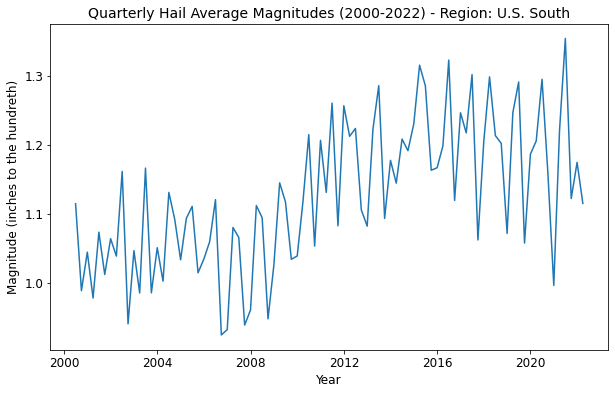

In [61]:
# Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. South

plot_series(hail, ['avg_mag'], title='Quarterly Hail Average Magnitudes (2000-2022) - Region: U.S. South', xlab='Year', ylab='Magnitude (inches to the hundreth)', steps=4)

---
## 4. Trends

### 4.1. Seasonality

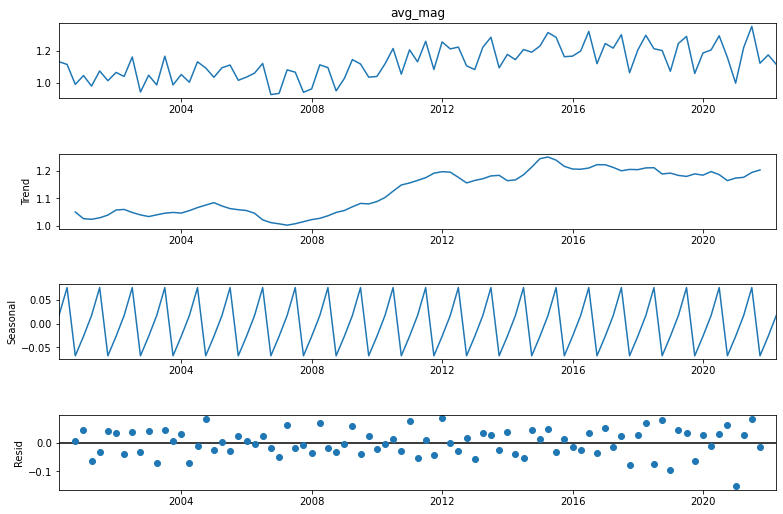

In [30]:
decomp = seasonal_decompose(hail['avg_mag'])

decomp.plot();
fig = plt.gcf()
fig.set_size_inches(12, 8)

In the trend component, we see that the averages have increased over time.

In the seasonal component, we see that there appears to be some seasonality detected. But this seasonal view can sometimes be misleading, so I'll need to run some additional diagnostics.

In the resid component, we see that there's quite a bit of variability that can not be explained by the model.

### 4.2. Autocorrelation

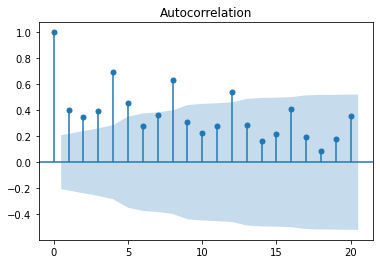

In [31]:
plot_acf(hail['avg_mag']);

For trend, the first 5 lags extend beyond the blue region, which represents a 95% confidence interval, meaning that there do seem to be trends present in the data.

For seasonality, the fluctuations do seem to occur with a fixed and known frequency and therefore, indicates that there may be seasonality present in the data.

For lags, it seems that using the first five will be useful to include in the model, as they extend beyond the blue region. While there are later lags that also extend beyond the blue region, there are lags in between them that do not, thereby making them lags that are not likely to improve model performance.

### 4.3. Partial Autocorrelation

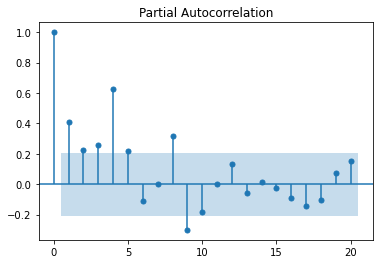

In [32]:
plot_pacf(hail['avg_mag']);

For seasonality, contrary to the autocorrelation, the fluctuations no longer occur with a fixed and known frequency and therefore, determines that there is no seasonality present.

For lags, the first 5 continue to extend beyond the blue region, though with lower correlations, and continue to be likely to be useful in the model.

### 4.4. Stationarity

In [33]:
# Dickey-Fuller Stationarity Test

adfuller(hail['avg_mag'])

(-1.169575347904694,
 0.6865448302039543,
 8,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 -197.579351271537)

The first 2 statistics of the test results tell me that the data is not stationary.

The 'test statistic', the first statistic, needs to be less than the critical values, which are the 1%, 5% and 10% values, and it is not. The p-value, the second statistic, needs to be less than the alpha of 0.05, and it is not. As a result, I'll need to difference the data.

### 4.5. Differencing

In [34]:
# Differencing the data

hail['first_diff'] = hail['avg_mag'].diff()

In [35]:
# Dropping any null values as a result of the differencing

hail.dropna(inplace=True)

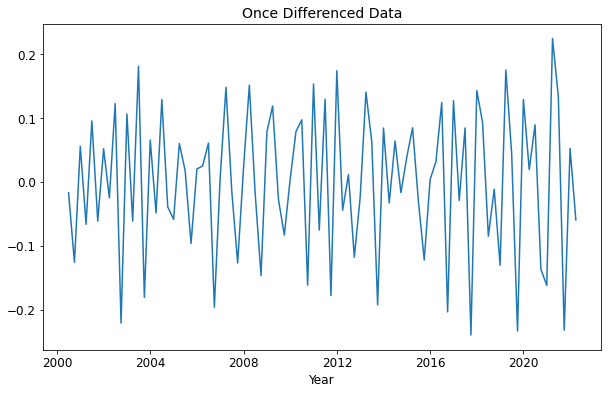

In [36]:
plot_series(hail, ['first_diff'], title='Once Differenced Data', xlab='Year', steps=4)

In [37]:
# Checking for the stationarity of the once differenced data

adfuller(hail['first_diff'])

(-3.6578275793855375,
 0.004747005519434078,
 7,
 80,
 {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625},
 -194.2375858169114)

The test statistic is now less than the critical values and the p-value is less than the alpha of 0.05. The data is now stationary and can be modeled on with ARIMA.

---
## 5. ARIMA Time Series Modeling

### 5.1. Train-Test Split

In [38]:
y_train, y_test = train_test_split(hail['first_diff'], test_size=0.1, shuffle=False)

### 5.2. GridSearch for best AIC, p & q

Because I needed to difference the data once, I know that the d parameter for the ARIMA model is 1. Given that, I'll run a GridSearch for the most optimal p & q.

In [39]:
best_aic = 1_000_000_000
best_p = 0
best_q = 0

for p in range(5):
    for q in range(5):

        try:
            
            arima = ARIMA(endog = y_train.astype(float).dropna(),
                         order=(p, 1, q))
            
            model = arima.fit(method_kwargs={"warn_convergence": False})

            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_p = p
                best_q = q

        except Exception as e:
            print(e)
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

The AIC for ARIMA(0,1,0) is: -36.07693229737554
The AIC for ARIMA(0,1,1) is: -114.81946038231223
The AIC for ARIMA(0,1,2) is: -159.50350885023084


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The AIC for ARIMA(0,1,3) is: -161.735392507124
The AIC for ARIMA(0,1,4) is: -164.8759562087031
The AIC for ARIMA(1,1,0) is: -79.88347548373721
The AIC for ARIMA(1,1,1) is: -134.405983040449
The AIC for ARIMA(1,1,2) is: -158.56459152183868
The AIC for ARIMA(1,1,3) is: -161.9269545863404
The AIC for ARIMA(1,1,4) is: -160.21482803031537
The AIC for ARIMA(2,1,0) is: -87.31019161941433


/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


The AIC for ARIMA(2,1,1) is: -141.12485626334222
The AIC for ARIMA(2,1,2) is: -135.44515361426858
The AIC for ARIMA(2,1,3) is: -159.85431703912508
The AIC for ARIMA(2,1,4) is: -158.45409628503913
The AIC for ARIMA(3,1,0) is: -138.82143696143388
The AIC for ARIMA(3,1,1) is: -181.93101383900827
The AIC for ARIMA(3,1,2) is: -181.1801555447641
The AIC for ARIMA(3,1,3) is: -176.45327112287623
The AIC for ARIMA(3,1,4) is: -190.75203472008786
The AIC for ARIMA(4,1,0) is: -167.88070648798438
The AIC for ARIMA(4,1,1) is: -181.76592301933596
The AIC for ARIMA(4,1,2) is: -180.94224180902432
The AIC for ARIMA(4,1,3) is: -187.83528314203178
The AIC for ARIMA(4,1,4) is: -184.67677625542825


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(3,1,4).
This model has an AIC of -190.75203472008786.


The p, d, q combination that returned the lowest AIC was when p=3, d=1, and q=4. This means that the model will perform best with the use of 3 lags, once differenced data, and a moving average window of 4. As such, the order of (3,1,4) will be used in the ARIMA model.

### 5.3. Instantiate & Fit

In [40]:
model = ARIMA(endog=y_train.astype(float).dropna(), order = (3,1,4))

arima = model.fit()

/Applications/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 5.4. Test Forecast

In [41]:
# Checking how many quarters were considered as test data with a test size of 10%

len(y_test)

9

In [42]:
# Generating the forecast for those 9 quarters

forecast = arima.forecast(steps=9)
forecast

2020-03-31    0.032240
2020-06-30    0.022489
2020-09-30   -0.111818
2020-12-31    0.027934
2021-03-31    0.088260
2021-06-30   -0.011790
2021-09-30   -0.092210
2021-12-31    0.020254
2022-03-31    0.091875
Freq: Q-DEC, Name: predicted_mean, dtype: float64

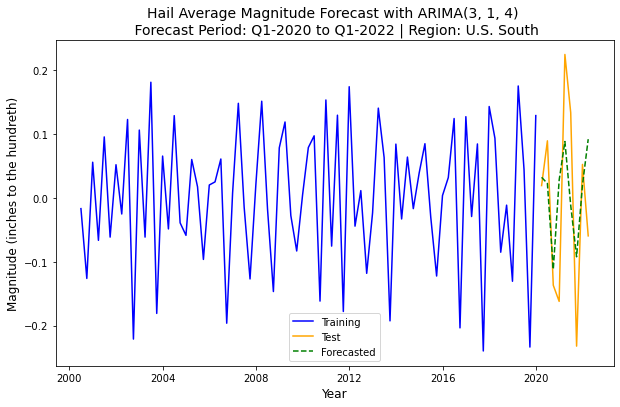

In [43]:
# Hail Average Magnitude Forecast with ARIMA(3, 1, 4) - Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. South

plt.figure(figsize=(10,6))
plt.plot(y_train.index, y_train, color='blue', label='Training')
plt.plot(y_test.index, y_test, color='orange', label='Test')
plt.plot(y_test.index, forecast, color='green', label='Forecasted', linestyle='--')

plt.title(label = 'Hail Average Magnitude Forecast with ARIMA(3, 1, 4) \n Forecast Period: Q1-2020 to Q1-2022 | Region: U.S. South', fontsize=14)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Magnitude (inches to the hundreth)', fontsize=12)

plt.legend();

Visually, the model seems to have forecasted decently. It does attempt to follow the increases and decreases, though not to their full extent.

### 5.5. Test Evaluation

In [44]:
r2 = r2_score(y_test, forecast)
print('R2: ' + str(r2))

R2: 0.31253086883465653


The model is able to explain 31% of the variability in the data.

In [45]:
rmse = mean_squared_error(y_test, forecast, squared=False)
print('RMSE: ' + str(rmse))

RMSE: 0.11761550052526638


In [46]:
hail.describe()

,avg_mag,first_diff
count,88.000000,88.000000
mean,1.125447,-0.000187
std,0.104126,0.113613
min,0.923972,-0.239646
25%,1.049427,-0.068716
50%,1.117019,0.009566
75%,1.206552,0.085944
max,1.353792,0.224514


The RMSE of 0.118 exceeded the standard deviation of 0.114. This model's forecasts are not reliable by these evaluation metric's standards.